Star-Galaxy seperation Test notebook.  

Chris W. and Sam S. for the SV bootcamp.  First version on 05/31/18.

In this notebook we use a the HSC dataset to test:

- calculating the extendedness variables
- Udnerstanding the various data products avaliable to the butler.
- Including color-color info in star-galaxy information (did not get to this)

In [2]:
import glob
import numpy as np
import pandas as pd

from collections import OrderedDict

import lsst.daf.persistence as daf_persistence
import lsst.afw.display as afw_display
from lsst.afw.geom import Point2D

%matplotlib inline
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.rcParams['savefig.dpi'] = 140
plt.rcParams['figure.dpi'] = 140

Define a function to RA and DEC center of a patch in a tract.

In [3]:
def getPatchCenter(skymap, tract, patch):
    '''
    Find the center of the patch BBox in pixel coordinates and convert with tract WCS
    An example of the format is:
    tract = 1800
    patch = '4,4'
    '''
    
    # Convert strings to ints
    patch = list(map(int, patch.split(','))) 

    # Get WCS for this tract
    wcs = skymap.generateTract(tract).getWcs()

    # Get four corners of patch
    bbox = skymap.generateTract(tract).getPatchInfo(patch).getInnerBBox() 

    # Manually calculate the center of the patch and then return the values converted to degrees
    sky = wcs.pixelToSky(np.mean((bbox.getBeginX(), bbox.getEndX())), 
                         np.mean((bbox.getBeginY(), bbox.getEndY())))
    return sky[0].asDegrees(), sky[1].asDegrees()

First open the HSC datafiles with the Butler

In [4]:
depth = 'DEEP'
butler = daf_persistence.Butler('/datasets/hsc/repo/rerun/DM-13666/{:s}/'.format(depth))

# In the generation 2 butler it isn't possibe to introspect the metadata for any step after the initial
# data ingest.  This code parses the names of the files to build a dataframe for later inspection.

infiles = glob.glob('/datasets/hsc/repo/rerun/DM-13666/{:s}/deepCoadd-results/HSC-I/*/*/calexp-*.fits'
                    .format(depth))

# Get the skymap for the repo so we can understand where the tracks and patches are
skymap = butler.get('deepCoadd_skyMap')


# Now get the names of the tracts and patches based on the file parsing
tract_array = []
patch_array = []
for i in range(0, len(infiles)):
    parts = infiles[i].split('/')
    tract_array.append(int(parts[-3]))
    patch_array.append(parts[-2])

number_patches = len(patch_array)

# Create arrays to hold the RA and DEC of the centers of the patches
ra_center_array = np.empty(number_patches, dtype=np.float)
dec_center_array = np.empty(number_patches, dtype=np.float) 

# Loop through the patches and figure out where their centers are in degrees
for index, (tract, patch) in enumerate(zip(tract_array, patch_array)):
    ra_center_array[index], dec_center_array[index] = getPatchCenter(skymap, tract, patch)
    
print('Found {:d} patches'.format(number_patches))

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Found 1303 patches


In [5]:
# Make a pandas dataframe with information on each tract and patch
data = OrderedDict({'tract': tract_array,
        'patch': patch_array, 
        'ra_center': ra_center_array, 
        'dec_center': dec_center_array})

df_tract_patch = pd.DataFrame(data=data)

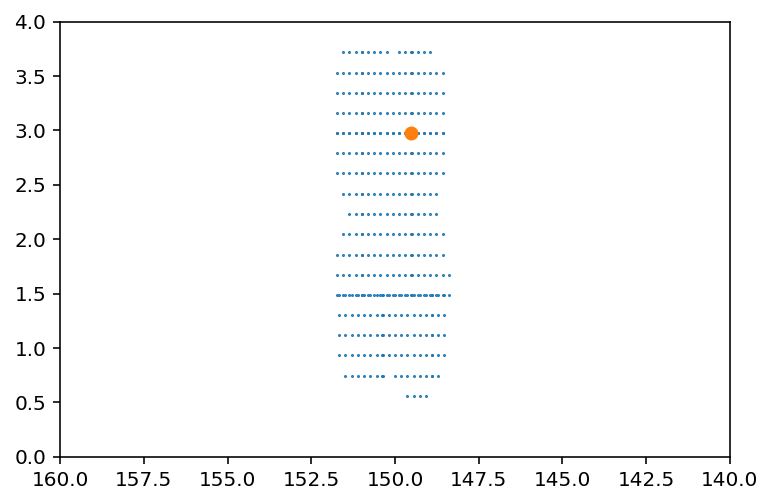

In [11]:
# Make sure the readout of the tract patch metadata file looks reasonable
plt.figure()
plt.scatter(df_tract_patch.ra_center, df_tract_patch.dec_center, marker='.', s=1)
# Centered on COSMOS field
plt.xlim(160., 140.)
plt.ylim(0., 4.)

# Pick one tract

#df_tract_patch.query('ra_center > 140 & ra_center < 160 & dec_center<4')
# selected_patch = df_tract_patch.query("tract==10056 and patch == '7,0'")
selected_patch = df_tract_patch.query("tract==10054 and patch == '0,0'")
plt.scatter(selected_patch.ra_center, selected_patch.dec_center)

Use the Butler to grab the information on the patches select columns and put them in a dataframe.

There are several catalogs you can use.  Our understanding and when to use them are as follows:

- 'deepCoadd_calexp' - Calibrated images + Calibration information including zeropoints and the PSF model 
- 'deepCoadd_calexp_calib' - The same but without the image. Smaller in memory.

- 'deepCoadd_meas' - Single band measurements.  Good if you only care about measurements in that band.

- 'deepCoadd_ref'  - Table describing all sources which will be maesured with forced photometry. The selected reference band for the position and model is given in the set of flags labeled merge_measurement_BAND.  

- 'deepCoadd_forced_src' - Forced photometry in each band of the reference catalog sources.  Seems to be line by line the same as the deepCoadd_ref sources.  They share an ID along with many other columns. Note detect_isPrimary is not in the forced_source catalog.  Once must use the reference catalog.

In [42]:
%%time 

# Create a dataid
filter_id = 'HSC-I'
tract_id = selected_patch.tract.values[0]

# loop over the patches creating a reduced dataframe for each patch
patch_sources = []

for patch_id in selected_patch.patch.values:
    # print(patch_id)
    # Use the butler to grab the information of this patch
    data_id = {'filter':filter_id, 'tract':tract_id, 'patch':patch_id}
    coadd_calexp = butler.get('deepCoadd_calexp', dataId=data_id)
    coadd_calib = butler.get('deepCoadd_calexp_calib', dataId=data_id)
    coadd_forced_src = butler.get('deepCoadd_forced_src', dataId=data_id)
    coadd_ref = butler.get('deepCoadd_ref', dataId=data_id)
    coadd_meas =  butler.get('deepCoadd_meas', dataId=data_id)
    
    sources_df = coadd_ref.asAstropy().to_pandas()
    forced_df  = coadd_forced_src.asAstropy().to_pandas()
    
    restricted_columns = ['coord_ra','coord_dec',
                          'detect_isPrimary', 
                          'base_PixelFlags_flag_interpolatedCenter', 'base_PixelFlags_flag_saturatedCenter',
                          'base_PsfFlux_flag', 'modelfit_CModel_flag',
                          'base_SdssCentroid_flag',
                          'slot_Centroid_x','slot_Centroid_y',
                          'slot_PsfFlux_flux', 
                          'base_PsfFlux_flux', 'base_PsfFlux_fluxSigma',
                          'modelfit_CModel_flux', 'modelfit_CModel_fluxSigma',
                          'base_ClassificationExtendedness_value']

    # Note did not get to grabbing forced photometry information yet.
    forced_columns = []
    
    patch_sources.append(sources_df[restricted_columns])

# Combine the patch dataframes.
combined_sources = pd.concat(patch_sources)

CPU times: user 7.94 s, sys: 974 ms, total: 8.92 s
Wall time: 9.19 s


Show the combined sources.

In [33]:
combined_sources.head()

,coord_ra,coord_dec,detect_isPrimary,base_PixelFlags_flag_interpolatedCenter,base_PixelFlags_flag_saturatedCenter,base_PsfFlux_flag,modelfit_CModel_flag,base_SdssCentroid_flag,slot_Centroid_x,slot_Centroid_y,slot_PsfFlux_flux,base_PsfFlux_flux,base_PsfFlux_fluxSigma,modelfit_CModel_flux,modelfit_CModel_fluxSigma,base_ClassificationExtendedness_value
0,2.649312,0.053441,False,False,False,True,False,True,16739.0,3918.0,144.196217,144.196217,1.197544,148.529091,1.232416,NaN
1,2.649263,0.053430,False,False,False,True,True,True,16800.0,3905.0,10.628938,10.628938,0.986336,NaN,NaN,NaN
2,2.649248,0.053430,False,False,False,True,True,True,16818.0,3905.0,54.480221,54.480221,1.052173,NaN,NaN,NaN
3,2.649144,0.053430,False,False,False,True,True,True,16945.0,3905.0,23.966059,23.966059,1.027064,NaN,NaN,NaN
4,2.648963,0.053430,False,False,False,True,True,True,17167.0,3905.0,31.783065,31.783065,1.039115,NaN,NaN,NaN


Make a new dataframe with cuts applied

In [34]:
cut_primary = 'detect_isPrimary'

cut_pixel ='not (base_PixelFlags_flag_interpolatedCenter or \
    base_PixelFlags_flag_saturatedCenter)' 

cut_model = 'not (base_PsfFlux_flag or modelfit_CModel_flag)' 

cut_centroid = 'not base_SdssCentroid_flag'

# Not used below here
cut_flux = 'base_PsfFlux_flux > 0 and modelfit_CModel_flux > 0'
cut_star = 'base_ClassificationExtendedness_value == 0'
cut_list = [cut_primary, cut_pixel, cut_model, cut_centroid]

cut = ' and '.join(cut_list) 

selected_sources = combined_sources.query(cut)

Add some additional calculated quantities

In [ ]:
%%time

def add_columns_to_rows(row):
    '''Add calculated variables to the dataframe.'''
    
    # Convert fluxes to magnitudes
    # 
    # Note: make sure you actually use the getMagnitude function in this case.  
    # various corrections such as space dependent zeropoint will be accounted for here.

    # This is necessary to not have getMagnitude throw an exception if fluxes are negative.
    coadd_calib.setThrowOnNegativeFlux(False)

    (psfMag, psfMagError) = coadd_calib.getMagnitude(row.base_PsfFlux_flux, row.base_PsfFlux_fluxSigma )
    row['psfMag'] = psfMag
    row['psfMagError'] = psfMagError
    

    (cmodelMag, cmodelMagError) = coadd_calib.getMagnitude(row.modelfit_CModel_flux, row.modelfit_CModel_fluxSigma)
    row['cmodelMag'] = cmodelMag
    row['cmodelMagError'] = cmodelMagError
      
    return row

analysis_df = selected_sources.apply(add_columns_to_rows, axis=1)

Now plot quantities. First the extendeness variables as calculated by us.  The value is the difference between the PSFMag and CModel Magnitudes.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f948e2dda20>]],
      dtype=object)

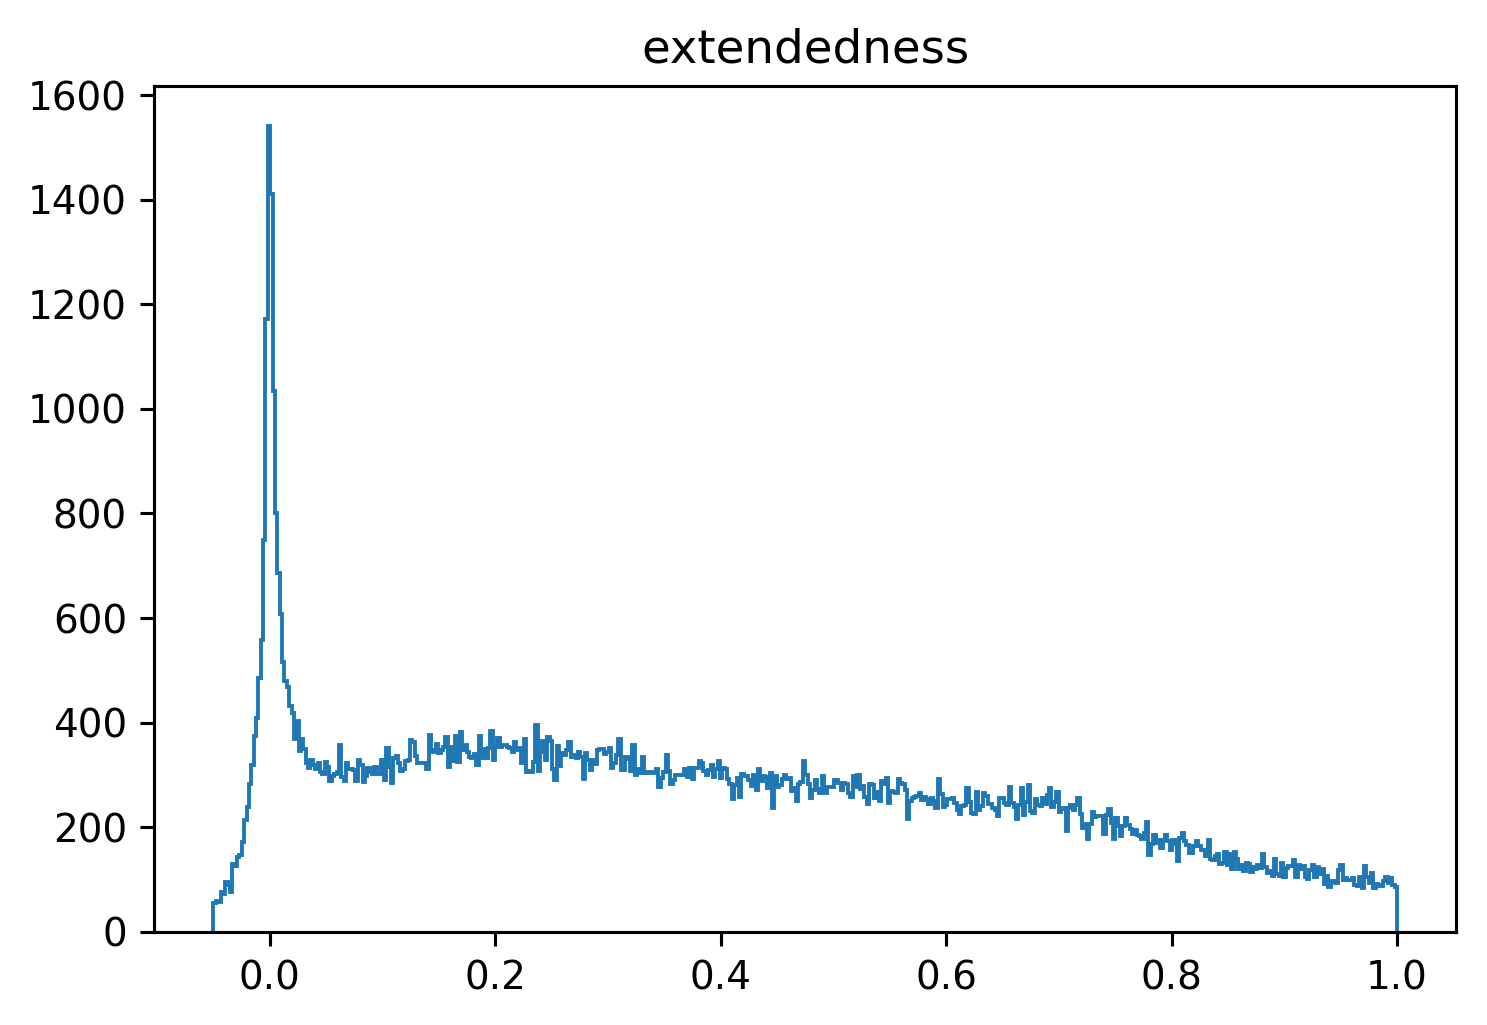

In [50]:
analysis_df.query('cmodelMag <= 26') \
                   .assign(extendedness = lambda x: x.psfMag - x.cmodelMag) \
                   .hist('extendedness', range=(-0.05, 1.0), bins=500, histtype='step', grid=False)

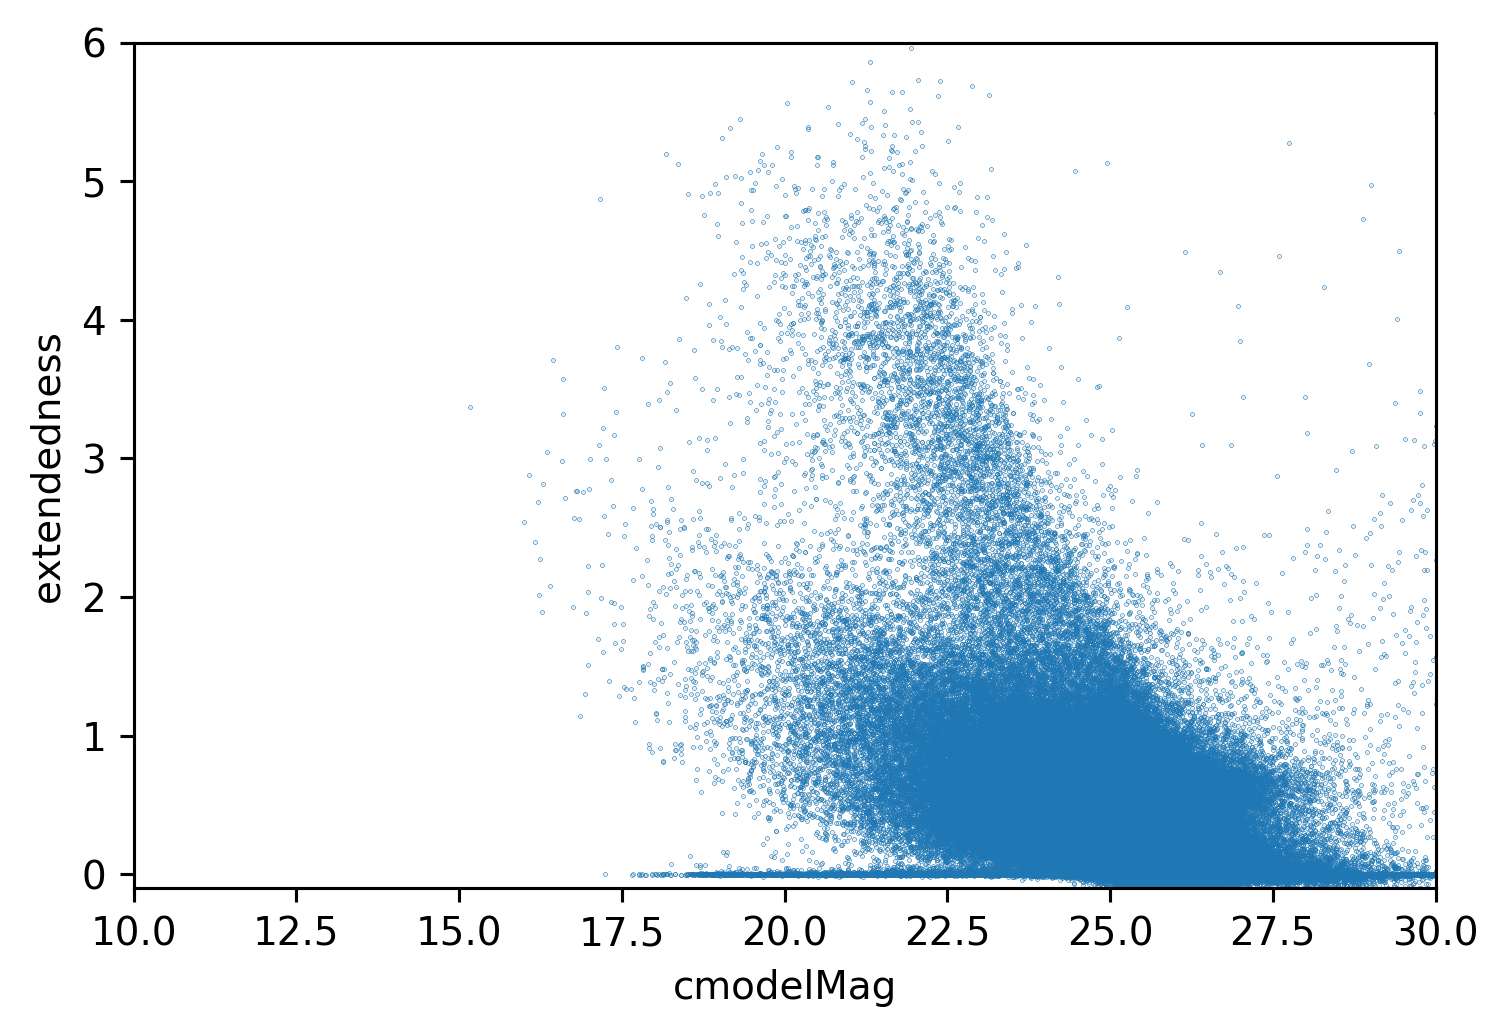

In [54]:
analysis_df.assign(extendedness = lambda x: x.psfMag - x.cmodelMag) \
                   .plot.scatter('cmodelMag','extendedness', marker=".", s=.1)

plt.xlim(10,  30)
plt.ylim(-0.1, 6);

Now plot the extendedness variable color coded with the project classification to compare against figure 16 of Bosch (2017) arxiv:1705.06766

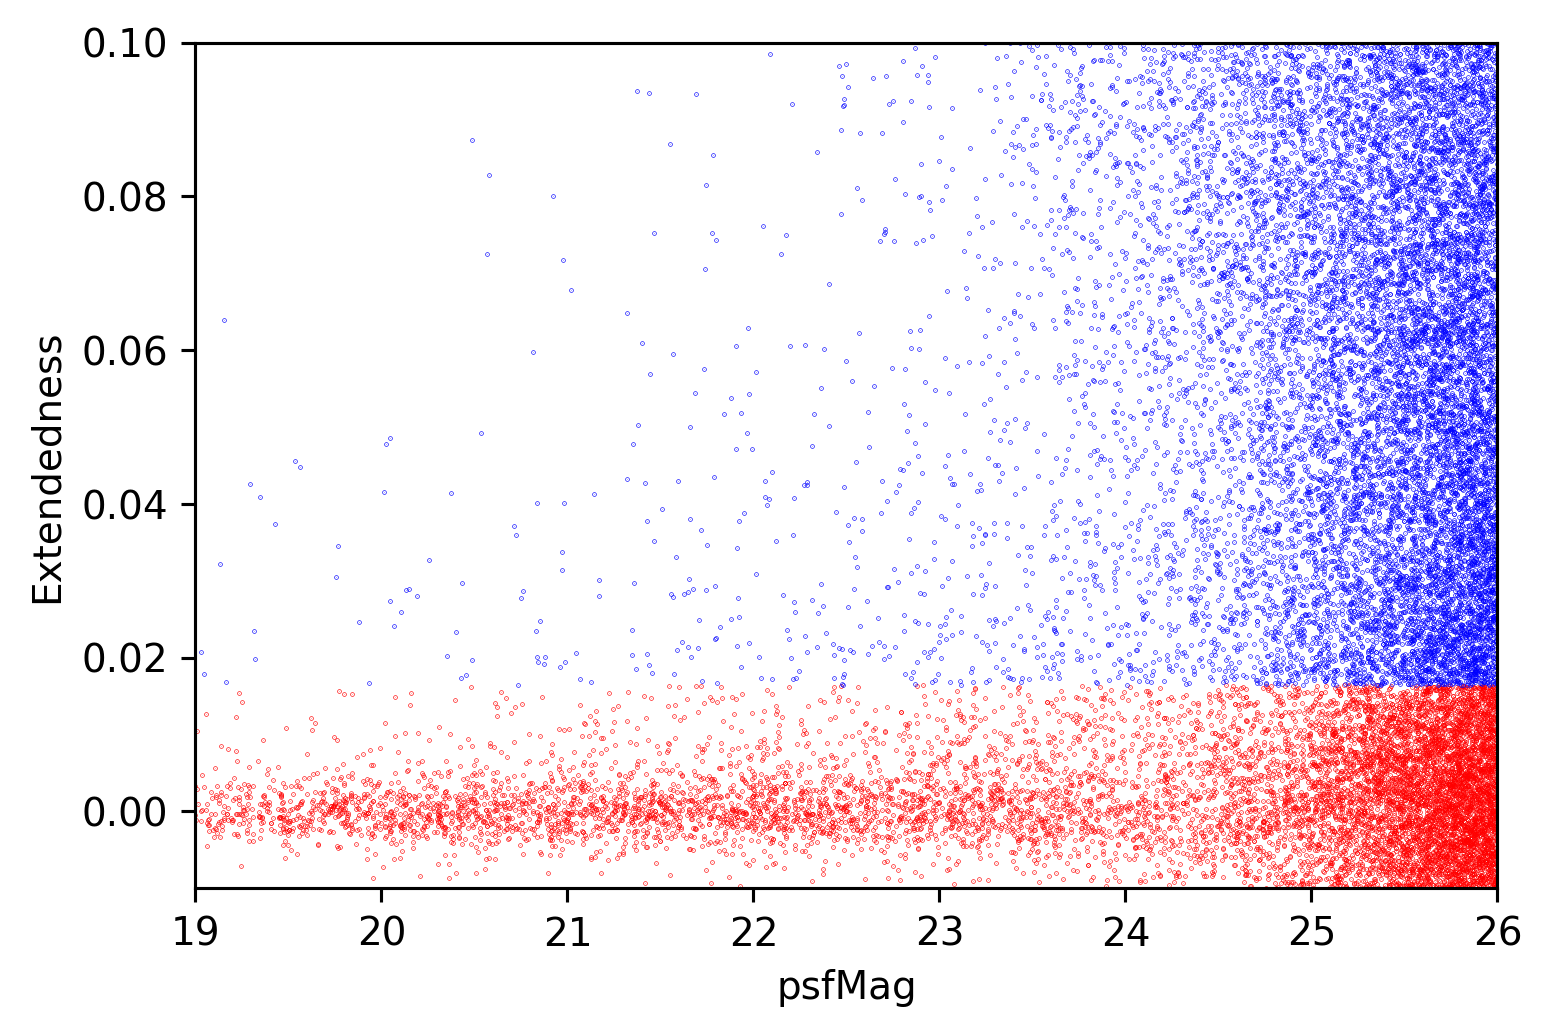

In [49]:
ax1 = analysis_df.query('base_ClassificationExtendedness_value == 0') \
                   .assign(extendedness = lambda x: x.psfMag - x.cmodelMag) \
                   .plot.scatter('cmodelMag','extendedness', marker=".", color='red', s=.1)

ax2 = analysis_df.query('base_ClassificationExtendedness_value == 1') \
                   .assign(extendedness = lambda x: x.psfMag - x.cmodelMag) \
                   .plot.scatter('cmodelMag','extendedness', marker=".", color='blue', s=.1, ax=ax1)

plt.xlim(19,  26)
plt.ylim(-0.01, 0.10);

plt.xlabel("psfMag")
plt.ylabel("Extendedness")

This is a trick to search for variables in a big data frame.

In [18]:
import re
mylist = combined_sources.columns.values.tolist()
[x for x in mylist if re.search('CM', x)]

['modelfit_CModel_flag', 'modelfit_CModel_flux', 'modelfit_CModel_fluxSigma']